In [17]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird eine lineare Funktion verwendet, um alle Werte von -1.5 bis 1.5 drin zu haben.

In [18]:
def fun(x):
    return -2+4*x

# x nicht überschreiben, das ist unsere CF für die Koordinaten...
xp = np.linspace(0,1,400)
fun_x = fun(xp)

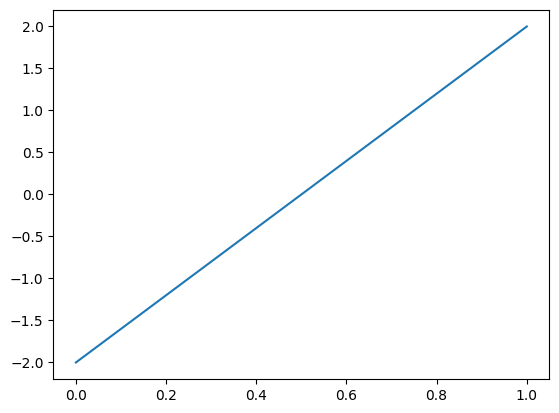

In [19]:
plt.plot(xp,fun_x)
plt.show()

In [20]:
#print(fun_x)

In [21]:
# generate a 1D mesh
ngmesh = NGMesh()
ngmesh.dim = 1

# Bem. stiw: wir brauchen etwas mehr Elemente als nur eines
nel = 200
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add(MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D(pnums[0], index=1))
ngmesh.Add (Element0D(pnums[nel], index=2))

mesh = Mesh(ngmesh)

In [22]:
# Startwerte:
t0 = 0
dt0 = 2.5e-1
tend = 2
eps0 = 1e-6
d2t = 0.000  #Änderungsrate für dt

# Initialisierung der Parameter
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [23]:
order = 2
V = H1(mesh, order=order)

In [24]:
# List für die gfu's initialisieren
gfu_array = []

for p in range (2,7):
    eps.Set(10**(-p))
    t.Set(t0)

    u = V.TrialFunction()
    v = V.TestFunction()
    gfu = GridFunction(V)
    a = BilinearForm (V, symmetric = False)
    a += Variation((eps/2*grad(u)*grad(u) 
                   +(u**2*(1-u*u)**2)
                   + 0.5/dt*(u-gfu)**2)*dx)
    
    # Interpolate the function onto the finite element space
    # Bem. stiw: hier können wir die Koordinaten CF benutzen
    u0 = GridFunction(V)
    u0.Set(-2+4*x)
    #oder
    u0.Set(fun(x))
    
    # Set the initial condition on the GridFunction
    gfu.Set(-2+4*x)
    


    
    res = gfu.vec.CreateVector()
    du = gfu.vec.CreateVector()
    
    # Newton Verfahren:
    for it in range(int((tend-t0)/dt.Get())):
        # Newton Verfahren
        for k in range(15):
            print("Newton iteration", k)    
            # solve linearized problem:
            # F(u_n)
            a.Apply(gfu.vec, res)
        
            # F'(u_n)   
            a.AssembleLinearization(gfu.vec)
        
            # F'(u_n) du = F(u_n)
            du.data = a.mat.Inverse(V.FreeDofs()) * res
        
            # update iteration
            # u_n+1 = u_n - du
            gfu.vec.data -= du
        
            # stopping criteria
            stopcritval = sqrt(abs(InnerProduct(du, res)))
            print("<A u", it, ", A u", it, ">_{-1}A0.S = ", stopcritval)
            print(gfu)
            if stopcritval < 1e-5:
                break
            
    
        # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
        t += dt.Get()
        print("abgelaufene Zeit: ", t)
        if t >= tend and stopcritval < 1e-5:
            break
    
    gfu_array.append(gfu)



Newton iteration 0
<A u 0 , A u 0 >_{-1}A0.S =  105.57147469792713
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
<A u 0 , A u 0 >_{-1}A0.S =  53.781129893576356
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
<A u 0 , A u 0 >_{-1}A0.S =  27.31777839453566
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
<A u 0 , A u 0 >_{-1}A0.S =  13.811151659320469
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 4
<A u 0 , A u 0 >_{-1}A0.S =  6.929977902997351
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 5
<A u 0 , A u 0 >_{-1}A0.S =  3.4346356094808477
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 6
<A u 0 , A u 0 >_{-1}A0.S =  1.6682534884469928
gridfunction 'gfu' on space 'H1HighOrderF

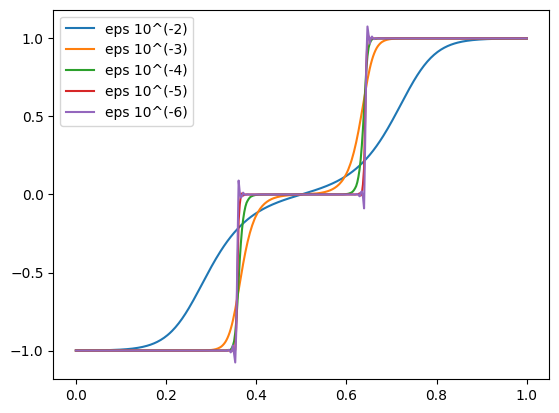

In [25]:
# Bem. stiw: Visualisierung

for p in range(len(gfu_array)):
    plt.plot(xp,gfu_array[p](mesh(xp)).flatten(), label=f'eps 10^(-{p+2})')


plt.legend()
plt.show()